## 可视化类激活图随模型训练而动态变化的过程

- 自定义能够存储输出层历史权重矩阵的回调函数

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16, InceptionV3
from keras.applications.vgg16 import preprocess_input, decode_predictions
# from utils import make_parallel
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


## 1. 载入训练集

- 从硬盘读取25000张猫狗图片，存入data
- 定义训练集配套的图片类型标签，存入label
- 将训练集进一步划分为训练集和验证集

In [2]:
path = os.getcwd() + '\\train\\'
label = np.array([0] * 12500 + [1] * 12500)
data = np.zeros((25000, 224, 224, 3), dtype=np.uint8)

for i in tqdm(range(12500)):
    img = cv2.imread(path + 'cat\\' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (224, 224))
    data[i] = img
    
for i in tqdm(range(12500)):
    img = cv2.imread(path + 'dog\\' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (224, 224))
    data[i+12500] = img
    
print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

100%|███████████████████████████████████████████████████| 12500/12500 [00:28<00:00, 436.55it/s]


Training Data Size = 3.50 GB


In [53]:
X_train, X_val, y_train, y_val = train_test_split(data, label, shuffle=True, test_size=0.2, random_state=42)

## 2. 创建模型

- 基模型直接使用只含卷积层部分的预训练 `VGG16` 模型
- 在基模型的基础上追加GAP、Dropout、Dense，即分类器部分
- 由于要解决的是二分类问题，因此使用 `binary_crossentropy` 作为损失函数，y也不用 one-hot 编码了
- 采用 Transfer Learning 策略：锁定 base_model 所有层的参数，仅允许训练分类器部分的参数（只有512+1=513个参数）


In [4]:
base_model = VGG16(include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
from keras import backend as K

def get_params_count(model):
    trainable = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable, non_trainable

print('Trainable Parameters: ', get_params_count(model)[0])

Trainable Parameters:  513


## 3. 训练模型

- 想要看到模型”成长的过程“，就需要了解模型在每个Batch后权重更新的状态。具体在这里，由于由于模型的卷积层参数已经冻结，并不会对模型的成长有任何贡献，因此实际上模型的进化过程完全由输出层的这513个权重参数决定。

- 具体实现上，我们需要定义一个Lambda Callback，用来备份在每个batch结束时最后一层的权重数值。

- 模型仅经过一代训练就可以达到 94.5% 的验证集准确率，我们应该能在稍后的处理之后欣赏到模型从50%上升到94.5%的完整心路历程。

In [3]:
from keras.callbacks import LambdaCallback
weights_history = []
get_weights_cb = LambdaCallback(on_batch_end=lambda batch, 
                                logs: weights_history.append(model.layers[-1].get_weights()[0]))

In [5]:
history = model.fit(x=X_train, y=y_train, 
                    batch_size=16, 
                    epochs=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=[get_weights_cb])

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 230s - loss: 0.6573 - acc: 0.8566 - val_loss: 0.1929 - val_acc: 0.9442


In [6]:
import pickle
with open('weights_history.p', 'wb') as f:
    pickle.dump(weights_history, f)

In [7]:
with open('weights_history.p', 'rb') as f:
    lalala = pickle.load(f)

## 4. 权重处理

$$
\begin{matrix}
\mathbf{Input} & \longrightarrow & \mathbf{CONV ~ Output} & \longrightarrow & \mathbf{GAP ~ Output} & \stackrel{\color{red}{W^{(512)}}}{\longrightarrow} & \mathbf{Dense} ~ \mathrm{(Sigmoid)} ~ \mathbf{Output}\\[2ex]
[224, ~224, ~3] && [7, ~7, ~512] && [~512~] && [~1~]
\end{matrix}
$$

- 对于同一张图片，由于基模型恒定不变，因此 $\mathbf{CONV ~ Output}$（特征图集 Feature Maps）固定不变， 也就是下面的 out_base
- 从 $\mathbf{CONV ~ Output}$ 到最后预测的概率值还要先经过全局平均池化、乘以权重、经过Sigmoid这三步才能得到，直接用下面的函数手动实现了下

In [60]:
target = data[1][:, :, ::-1]

In [61]:
out_base = base_model.predict(np.expand_dims(target, axis=0))
out_base = out_base[0]
print(out_base.shape)

(7, 7, 512)


In [62]:
# 根据卷积层输出特征图集和模型某一参数状态计算预测概率（为了简单省略了bias计算）
def predict_on_weights(out_base, weights):
    gap = np.average(out_base, axis=(0, 1))
    logit = np.dot(gap, np.squeeze(weights))
    return 1 / (1 +  np.e ** (-logit))

predict_on_weights(out_base, weights_history[42])

0.37235825669154349

## 5. 类激活图计算

- 类激活图其实就是将卷积层输出的特征图按输出层分类器的权重进行加权合成的一副图样
- 基本流程
    - **归一化**：由于ColorMap的工作原理是将任意矩阵的取值范围映射到0~255范围内，因此为了之后好挑选颜色，需要归一化一下。
    - 手动放大至[0,255]
    - 元素格式化
    - **设定门限**：由于只希望将模型认为比较重要的区域标记出来，因此应该选择一个门限值，将该门限值之下的像素位置至0（此时该像素透明）
    - 在图像本体添加文字标注（方便之后导出为视频）

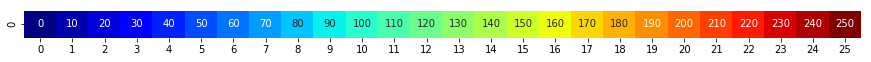

In [69]:
import seaborn as sns
plt.figure(figsize=(15, 0.5))
band = np.array([list(np.arange(0, 255, 10))] * 1)
sns.heatmap(band, annot=True, fmt="d", cmap='jet', cbar=False)
plt.show()

In [64]:
def getCAM(weights, display=False):
    
    predict = predict_on_weights(out_base, weights)
    
    # Weighted Feature Map
    cam = (predict - 0.5) * np.matmul(out_base, weights)
    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    # Resize as image size
    cam_resize = cv2.resize(cam, (224, 224))
    # Format as CV_8UC1 (as applyColorMap required)
    cam_resize = 255 * cam_resize
    cam_resize = cam_resize.astype(np.uint8)
    # Get Heatmap
    heatmap = cv2.applyColorMap(cam_resize, cv2.COLORMAP_JET)
    # Zero out
    heatmap[np.where(cam_resize <= 100)] = 0
    
    out = cv2.addWeighted(src1=target, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
    out = cv2.resize(out, dsize=(500, 500))
    
    if predict < 0.5:
        text = 'cat %.2f%%' % (100 - predict * 100)
    else:
        text = 'dog %.2f%%' % (predict * 100)
        
    cv2.putText(out, text, (290, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, 
                  color=(123,222,238), thickness=2, lineType=cv2.LINE_AA)
    if display:
        cv2.imshow('img', out)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return out

In [65]:
getCAM(weights_history[1000], display=True);

## 6. 导出视频

- 视频就是一个播放的很快的图片幻灯片
- 使用VideoWriter生成视频，由于iOS使用的是H.264，这里用MP4格式。

In [66]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('outputx.mp4',fourcc, 20.0, (500, 500))

for i in range(1250):
    img = getCAM(weights_history[i])
    out.write(img)
    cv2.imshow('frame', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()